In [6]:
# Code for calculating periodicities in Venus Brightness Data
# by Pushkar Kopparla (pushkarkopparla@gmail.com)
# For reference please see: Kopparla, P., Lee, Y. J., Imamura, T., & Yamazaki, A. (2019). 
# Principal components of short-term variability in the ultraviolet albedo of Venus. Astronomy & Astrophysics, 626, A30.
# https://doi.org/10.1051/0004-6361/201935388
# written for Python 2.7 using Anaconda distribution version 1.7.0 Jupyter 5.4.0 Ipython 5.4.1

import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.ndimage import filters
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import curve_fit
from astropy.stats import LombScargle
from scipy.signal import find_peaks

fileText = open('RedNoiseSignificance_Inputdata.txt','r') #datafile with dates and brightness values
linecount = 2332
date = np.zeros(linecount)
alb = np.zeros([16,linecount])
for count in range(linecount):# read in data from file into arrays, first column date, next 16 columns brightness, 2332 rows
    temp = fileText.readline().split()
    date[count] = temp[0]#time in units of days
    alb[:,count] = temp[1:]#brightness value range of 0-1
fileText.close()

In [13]:
freq = np.logspace(-3,0,num=1500) #choose the frequency points at which the spectral power is calculated
#freq,power = LombScargle(date,alb).autopower(minimum_frequency=1/1000.,maximum_frequency=1.)

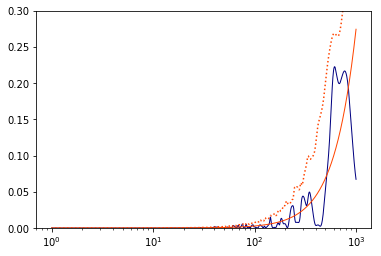

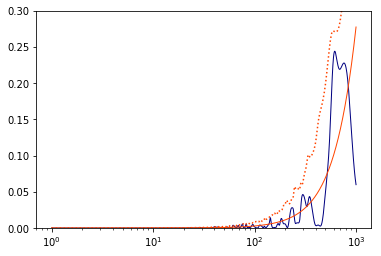

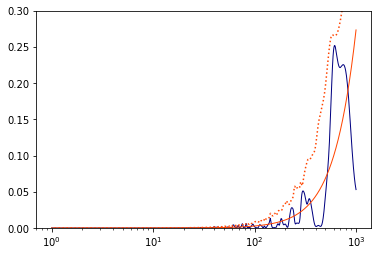

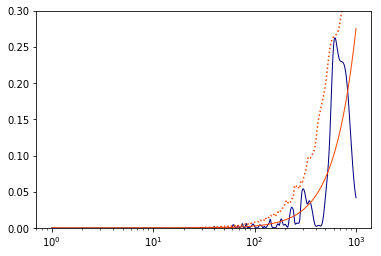

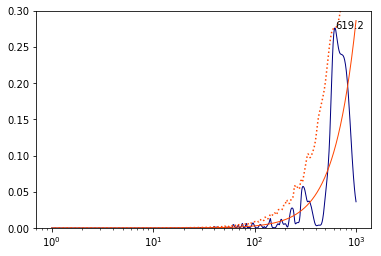

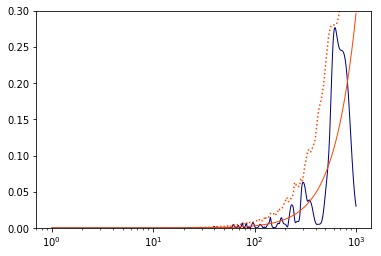

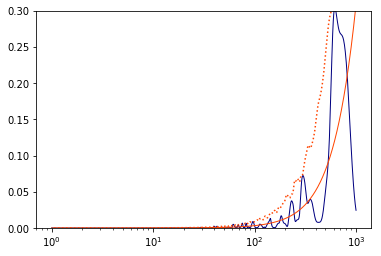

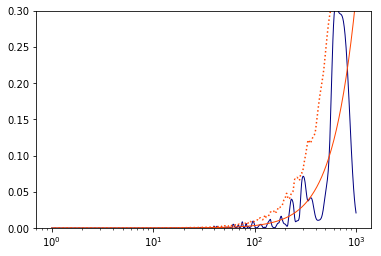

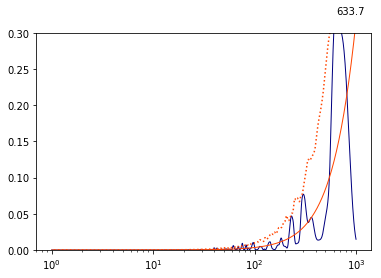

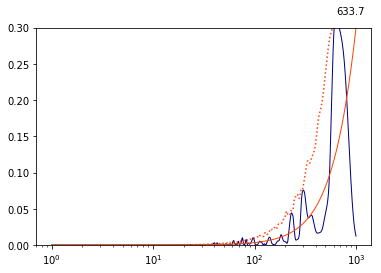

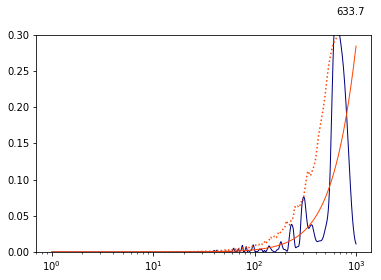

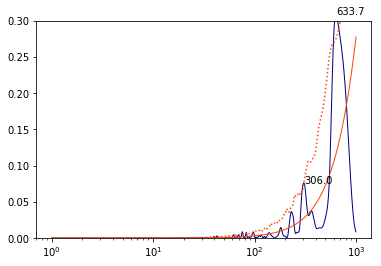

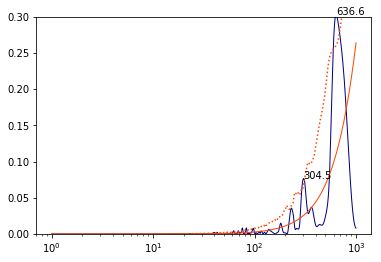

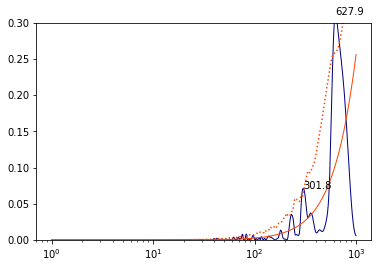

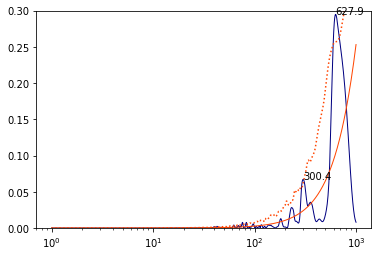

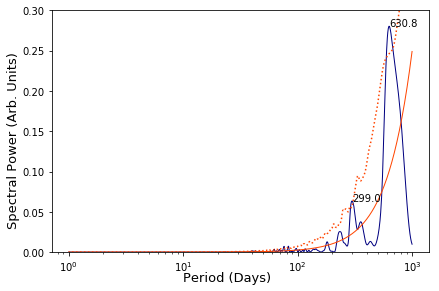

In [12]:
def rednoisefn(inp,tau):#function for estimating the persistence timescale of the autocorrelated timeseries 
    x,t = inp
    return x*np.exp(-t/tau)
for pc in range(16):
    origData = alb[pc,:]
    datesDiff = np.diff(date)

    persisTime,pcov = curve_fit(rednoisefn, (origData[:-1],datesDiff), origData[1:]) #estimate persistence timescale and uncertainity
    power = LombScargle(date,origData).power(freq) #raw Lomb Scargle periodogram
    origArea = integrate.simps(power,1/freq)
    artNum = 1000 #no of simulated pure noise timeseries
    simpower = np.zeros([artNum,freq.size]) #second index is number of frequencies
    for i in range(artNum): 
        simData = np.zeros_like(origData)
        for count,timestep in enumerate(datesDiff):
                if count==0:
                    simData[0]=origData[0] #initialize noise timeseries with first data point
                else:
                    simData[count] = simData[count-1]*np.exp(-timestep/persisTime) + \#create subsequent noise timeseries points
                    np.random.normal(loc=0,scale=np.sqrt(1-np.exp(-2*timestep/persisTime)))
        simfreq = freq
        simpower[i,:] = LombScargle(date,simData).power(freq)#periodogram of pure noise timeseries
        simpower[i,:] = simpower[i,:]*origArea/integrate.simps(simpower[i,:],1/simfreq)#normalized to area of curve
        
    avgSim = np.mean(simpower,axis=0)# mean of 1000 simulated pure noise timeseries
    avgSpread = np.std(simpower,axis=0)# standard deviation
    avgStep = np.mean(datesDiff)
    rho = np.exp(-avgStep/persisTime)
    analySpec = (1-rho**2)/(1-2*rho*np.cos(np.pi*freq/np.amax(freq))+rho**2)#calculation of the analytical pure noise spectrum
    analySpec =  analySpec*origArea/integrate.simps(analySpec,1/simfreq)#normalize to area
    correFac = avgSim/analySpec#calculate correction factors
    fig = plt.figure()
    ax = plt.gca()
    noiseHeights = (avgSim+2*avgSpread)/correFac#2 sigma noise limtis
    noiseHeights[noiseHeights<0.03] = 0.03# minimum noise height to filter out high freq noise
    peaks, _ = find_peaks(power/correFac,height=noiseHeights)
    writefile = open('localtime%dcol.txt'%(pc+1),'w')
    for i in range(freq.size):
        #write out periodograms to file
        writefile.write('%f\t%f\t%f\t%f\t%f\n'%(1/freq[i],power[i]/correFac[i],avgSim[i]/correFac[i],(avgSim[i]+2*avgSpread[i])/correFac[i],correFac[i]))
    writefile.close()
    plt.plot(1/freq,power/correFac,'navy',linewidth=1)#plot corrected data periodogram
    plt.plot(1/freq,avgSim/correFac,'orangered',linewidth=1)#corrected average noise periodogram
    plt.plot(1/freq,(avgSim+2*avgSpread)/correFac,':',color='orangered')#corrected 2 sigma noise limits
    for i in range(peaks.size):
        plt.text(1/freq[peaks[i]],power[peaks[i]]/correFac[peaks[i]],'%0.1f'%(1/freq[peaks[i]]))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.xscale('log')
    plt.ylim([0,0.3])
fig.subplots_adjust(left=0.1, bottom = 0.2)
fig.text(0.5, 0.01, 'Period (Days)', ha='center',fontsize=13)
fig.text(-0.01, 0.5, 'Spectral Power (Arb. Units)', va='center', rotation='vertical',fontsize=13)
plt.tight_layout()
plt.show()